In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import random
import scipy.sparse as sp
from scipy import stats

import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

from tqdm.autonotebook import tqdm, trange

In [3]:
SEED = 42
if SEED is not None:
    np.random.seed(SEED)
    random.seed(SEED)

# 1. Датасет
Выбрал [movielens](https://grouplens.org/datasets/movielens/), так как он стал почти классикой, встречается почти во всех статьях  

Также очень удобно, что есть нексколько размеров, удобнее вначале тестировать на небольшом размере, а затем прогнать на большем  

На счет разделения на train/test: давайте для каждого пользователя поделим оцененные им фильмы в хронологическом порядке (т.е. первые 3/4 оценок отнесем в train, а оставшуюся четверть — в test). 

Плюсы: 
* train и test состоят из одинаковых пользователей (если предварительно оставить только тех, кто сделал не меньше 4 оценок)
* не мешаем по времени, можем применять различные техники для затухания

Минусы:
* не глобальная граница по времени (т.е. если разбить на train/test как раньше/после 01.01.2015, например) $\Longrightarrow$ чуточку заглядываем в будущее

In [4]:
from pathlib import Path

from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_stratified_split, python_chrono_split

In [5]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

In [6]:
data_path = Path('.')
ratings = movielens.load_pandas_df(MOVIELENS_DATA_SIZE, ('userID', 'itemID', 'rating', 'timestamp'),
            title_col='title',
            local_cache_path=data_path)

movie_info = movielens.load_item_df(size=MOVIELENS_DATA_SIZE, title_col='title', genres_col='genres', local_cache_path=data_path)

In [7]:
ratings.head()

,userID,itemID,rating,timestamp,title
0,1,1193,5.0,978300760,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5.0,978298413,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4.0,978220179,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4.0,978199279,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5.0,978158471,One Flew Over the Cuckoo's Nest (1975)


In [8]:
train, test = python_chrono_split(ratings, ratio=0.75, col_user='userID', col_item='itemID', col_timestamp='timestamp', )

In [9]:
test = test[test['itemID'].isin(train['itemID'].unique())]

train = train[train['itemID'].isin(test['itemID'].unique())]

In [10]:
train.shape, test.shape

((749841, 5), (250024, 5))

In [11]:
train.head()

,userID,itemID,rating,timestamp,title
34073,1,3186,4.0,978300019,"Girl, Interrupted (1999)"
37339,1,1022,5.0,978300055,Cinderella (1950)
31152,1,1721,4.0,978300055,Titanic (1997)
23270,1,1270,5.0,978300055,Back to the Future (1985)
28157,1,2340,3.0,978300103,Meet Joe Black (1998)


In [12]:
train_times = train.groupby(by='userID', as_index=False)['timestamp'].max()
test_times = test.groupby(by='userID', as_index=False)['timestamp'].min()

merged_times = train_times.merge(test_times, on='userID')

merged_times.head()

,userID,timestamp_x,timestamp_y
0,1,978302281,978824139
1,2,978299839,978299861
2,3,978298147,978298147
3,4,978294260,978294260
4,5,978245763,978245763


In [13]:
(merged_times['timestamp_x'] > merged_times['timestamp_y']).sum()

0

**нет пересечений по времени:** для каждого пользователя его первая оценка из test'а позже последней оценки из train'а

In [14]:
implicit_ratings_train = train.loc[(train['rating'] >= 4)]
implicit_ratings_test = test.loc[(test['rating'] >= 4)]

In [15]:
users = implicit_ratings_train["userID"]
movies = implicit_ratings_train["itemID"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

In [16]:
users_test = implicit_ratings_test["userID"]
movies_test = implicit_ratings_test["itemID"]
user_item_test = sp.coo_matrix((np.ones_like(users_test), (users_test, movies_test)))
user_item_test_csr = user_item_test.tocsr()

# 2-3. Сравнение
Давайте попробуем много моделек, и для каждой модели будем считать следующие метрики:
* map_at_k
* ndcg_at_k
* precision_at_k
* recall_at_k 

для $k \in [3, 5, 10]$


А также покажем похожие фильмы для:
* истории игрушек
* звездных войн

И предсказания для конкретных пользователей:
* 96, 734
(их история чуть ниже)

In [25]:
N_FACTORS = 64
TOP_K = 10
MOVIES_TO_SIMILAR = [1, 2628]
USERS_TO_RECOMMEND = [1, 4]

In [28]:
for user_to_recommend in USERS_TO_RECOMMEND:
    print(f'История просмотров пользователя: {user_to_recommend}')
    display(train[train['userID'] == user_to_recommend].sample(10))

История просмотров пользователя: 1


,userID,itemID,rating,timestamp,title
55246,1,3114,4.0,978302174,Toy Story 2 (1999)
10278,1,594,4.0,978302268,Snow White and the Seven Dwarfs (1937)
40375,1,150,5.0,978301777,Apollo 13 (1995)
16741,1,2791,4.0,978302188,Airplane! (1980)
13819,1,938,4.0,978301752,Gigi (1958)
14386,1,2918,4.0,978302124,Ferris Bueller's Day Off (1986)
28883,1,1097,4.0,978301953,E.T. the Extra-Terrestrial (1982)
45033,1,1962,4.0,978301753,Driving Miss Daisy (1989)
15859,1,1035,5.0,978301753,"Sound of Music, The (1965)"
46757,1,260,4.0,978300760,Star Wars: Episode IV - A New Hope (1977)


История просмотров пользователя: 4


,userID,itemID,rating,timestamp,title
223126,4,2947,5.0,978294230,Goldfinger (1964)
218554,4,2366,4.0,978294230,King Kong (1933)
164932,4,3418,4.0,978294260,Thelma & Louise (1991)
219310,4,1387,5.0,978294199,Jaws (1975)
45686,4,2692,5.0,978294230,Run Lola Run (Lola rennt) (1998)
133409,4,1198,5.0,978294199,Raiders of the Lost Ark (1981)
128355,4,1196,2.0,978294199,Star Wars: Episode V - The Empire Strikes Back...
70281,4,3468,5.0,978294008,"Hustler, The (1961)"
70732,4,1210,3.0,978293924,Star Wars: Episode VI - Return of the Jedi (1983)
221007,4,3527,1.0,978294008,Predator (1987)


In [29]:
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

def test_model_perfomance(model_predictions, get_similar_items_fn=None):
    if get_similar_items_fn:
        print('Похожие фильмы:')
        for movie_id in MOVIES_TO_SIMILAR:
            display(movie_info.set_index('itemID').loc[get_similar_items_fn(movie_id)])
        print('\n')
        
    for user_to_recommend in USERS_TO_RECOMMEND:
        print(f'Рекомендации для пользователя: {user_to_recommend}')
        display(model_predictions[model_predictions['userID']==user_to_recommend].merge(movie_info, on='itemID'))
    
    model_perfomance = {}
    
    for k in [3, 5, 10]:
        for metric in map_at_k, ndcg_at_k, precision_at_k, recall_at_k:
            metric_name = f"{metric.__name__.rpartition('_')[0]}_{k}"
            metric_value = metric(rating_true=test, rating_pred=model_predictions, k=k)
            model_perfomance[metric_name] = metric_value
    return model_perfomance

In [30]:
def get_metrics(groups) -> pd.DataFrame:
    metrics =  pd.DataFrame.from_records(groups, columns=groups.keys(), index=list(all_metrics.values())[0].keys())
    metrics.index.name = 'metric'
    return metrics

def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    metrics = get_metrics(groups)
    return metrics.subtract(metrics[control_name], axis='index').drop(columns=control_name) * 100


all_metrics = {}

# 2. Готовые модели
## 2.1 BayesianPersonalizedRanking [implicit](https://implicit.readthedocs.io/en/latest/bpr.html)

In [31]:
import implicit

In [32]:
model = implicit.bpr.BayesianPersonalizedRanking(factors=N_FACTORS, iterations=100)

In [33]:
model.fit(user_item_t_csr)

In [34]:
ratings_predictions = model.recommend_all(user_item_csr, N=TOP_K)

In [35]:
predictions = pd.DataFrame(np.arange(ratings_predictions.shape[0]), columns=['userID'])

predictions['itemID'] = ratings_predictions.tolist()

predictions = predictions[predictions['userID'].isin(users.unique())]

predictions = predictions.explode('itemID', ignore_index=True)

predictions['itemID'] = predictions['itemID'].astype(np.int64)

predictions['prediction'] = TOP_K - predictions.index % TOP_K

In [36]:
get_similars_fn = lambda item_id: np.array(model.similar_items(item_id), dtype=np.int)[:, 0]

In [37]:
all_metrics['bpr_implicit'] = test_model_perfomance(predictions, get_similar_items_fn=get_similars_fn)

Похожие фильмы:


,title,genres
itemID,,
1,Toy Story (1995),Animation|Children's|Comedy
3114,Toy Story 2 (1999),Animation|Children's|Comedy
2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
1566,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical
588,Aladdin (1992),Animation|Children's|Comedy|Musical
34,Babe (1995),Children's|Comedy|Drama
1907,Mulan (1998),Animation|Children's
2384,Babe: Pig in the City (1998),Children's|Comedy
2761,"Iron Giant, The (1999)",Animation|Children's


,title,genres
itemID,,
2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi
1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
329,Star Trek: Generations (1994),Action|Adventure|Sci-Fi
2393,Star Trek: Insurrection (1998),Action|Sci-Fi
316,Stargate (1994),Action|Adventure|Sci-Fi
3564,"Flintstones in Viva Rock Vegas, The (2000)",Children's|Comedy
1372,Star Trek VI: The Undiscovered Country (1991),Action|Adventure|Sci-Fi
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
251,"Hunted, The (1995)",Action




Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,595,10,Beauty and the Beast (1991),Animation|Children's|Musical
1,1,2565,9,"King and I, The (1956)",Musical
2,1,953,8,It's a Wonderful Life (1946),Drama
3,1,1012,7,Old Yeller (1957),Children's|Drama
4,1,2846,6,"Adventures of Milo and Otis, The (1986)",Children's
5,1,364,5,"Lion King, The (1994)",Animation|Children's|Musical
6,1,1947,4,West Side Story (1961),Musical|Romance
7,1,2739,3,"Color Purple, The (1985)",Drama
8,1,2085,2,101 Dalmatians (1961),Animation|Children's
9,1,2137,1,Charlotte's Web (1973),Animation|Children's


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,1196,10,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1,4,1214,9,Alien (1979),Action|Horror|Sci-Fi|Thriller
2,4,858,8,"Godfather, The (1972)",Action|Crime|Drama
3,4,1221,7,"Godfather: Part II, The (1974)",Action|Crime|Drama
4,4,589,6,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
5,4,2948,5,From Russia with Love (1963),Action
6,4,1291,4,Indiana Jones and the Last Crusade (1989),Action|Adventure
7,4,1036,3,Die Hard (1988),Action|Thriller
8,4,457,2,"Fugitive, The (1993)",Action|Thriller
9,4,2571,1,"Matrix, The (1999)",Action|Sci-Fi|Thriller


## 2.2 Simple Algorithm for Recommendation (SAR)
Similarity-based algorithm for implicit feedback dataset

In [38]:
from reco_utils.recommender.sar import SAR

In [39]:
model = SAR(
    col_user="userID",
    col_item="itemID",
    col_rating="rating",
    col_timestamp="timestamp",
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    timedecay_formula=True,
    normalize=True
)

In [40]:
model.fit(train)

In [41]:
def get_similars(item_id):
    items = pd.DataFrame(dict(itemID=[item_id]))
    return np.insert(model.get_item_based_topk(items, top_k=TOP_K - 1)['itemID'].values, 0, item_id)

In [42]:
top_k = model.recommend_k_items(test, remove_seen=True, top_k=TOP_K)

In [43]:
all_metrics['sar'] = test_model_perfomance(top_k, get_similar_items_fn=get_similars)

Похожие фильмы:


,title,genres
itemID,,
1,Toy Story (1995),Animation|Children's|Comedy
1265,Groundhog Day (1993),Comedy|Romance
3114,Toy Story 2 (1999),Animation|Children's|Comedy
588,Aladdin (1992),Animation|Children's|Comedy|Musical
34,Babe (1995),Children's|Comedy|Drama
2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
2396,Shakespeare in Love (1998),Comedy|Romance
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
356,Forrest Gump (1994),Comedy|Romance|War


,title,genres
itemID,,
2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
480,Jurassic Park (1993),Action|Adventure|Sci-Fi
780,Independence Day (ID4) (1996),Action|Sci-Fi|War
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller




Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,1196,3.960015,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1,1,2174,3.930943,Beetlejuice (1988),Comedy|Fantasy
2,1,1,3.811675,Toy Story (1995),Animation|Children's|Comedy
3,1,1198,3.800308,Raiders of the Lost Ark (1981),Action|Adventure
4,1,2716,3.784470,Ghostbusters (1984),Comedy|Horror
5,1,1265,3.782943,Groundhog Day (1993),Comedy|Romance
6,1,1259,3.777731,Stand by Me (1986),Adventure|Comedy|Drama
7,1,318,3.774453,"Shawshank Redemption, The (1994)",Drama
8,1,296,3.750475,Pulp Fiction (1994),Crime|Drama
9,1,2987,3.734323,Who Framed Roger Rabbit? (1988),Adventure|Animation|Film-Noir


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,1214,3.441302,Alien (1979),Action|Horror|Sci-Fi|Thriller
1,4,2571,3.424404,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2,4,589,3.402098,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
3,4,1036,3.377918,Die Hard (1988),Action|Thriller
4,4,1291,3.357371,Indiana Jones and the Last Crusade (1989),Action|Adventure
5,4,1200,3.356320,Aliens (1986),Action|Sci-Fi|Thriller|War
6,4,2916,3.255522,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller
7,4,457,3.188596,"Fugitive, The (1993)",Action|Thriller
8,4,1580,3.170550,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
9,4,1197,3.055662,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance


## 2.3 FastAI Embedding Dot Bias (FAST)
General purpose algorithm with embeddings and biases for users and items

In [44]:
import torch, fastai
from fastai.collab import EmbeddingDotBias, collab_learner, CollabDataBunch, load_learner
from reco_utils.recommender.fastai.fastai_utils import cartesian_product, score

In [45]:
USER, ITEM, RATING, TIMESTAMP, PREDICTION, TITLE = 'userID', 'itemID', 'rating', 'timestamp', 'prediction', 'title'

data = CollabDataBunch.from_df(train, user_name=USER, item_name=ITEM, rating_name=RATING, valid_pct=0)

learn = collab_learner(data, n_factors=N_FACTORS, y_range=[0,5.5], wd=1e-1)
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(6041, 64)
  (i_weight): Embedding(3514, 64)
  (u_bias): Embedding(6041, 1)
  (i_bias): Embedding(3514, 1)
)

In [46]:
learn.fit_one_cycle(5, max_lr=5e-3)

learn.export('movielens_model.pkl')

learner = load_learner(path=".", fname='movielens_model.pkl')

epoch,train_loss,valid_loss,time
1,0.946878,,00:54
2,0.889404,,00:55
3,0.815063,,00:53
4,0.783196,,00:52
5,0.731655,,00:51


In [47]:
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]

In [48]:
test_users = test[USER].unique()
test_users = np.intersect1d(test_users, total_users)

In [49]:
users_items = cartesian_product(np.array(test_users),np.array(total_items))
users_items = pd.DataFrame(users_items, columns=[USER,ITEM])

In [50]:
training_removed = pd.merge(users_items, train.astype(str), on=[USER, ITEM], how='left')
training_removed = training_removed[training_removed[RATING].isna()][[USER, ITEM]]

In [51]:
top_k_scores = score(learner, 
                     test_df=training_removed,
                     user_col=USER, 
                     item_col=ITEM, 
                     prediction_col=PREDICTION)

top_k_scores['userID'], top_k_scores['itemID'] = top_k_scores['userID'].astype(np.int), top_k_scores['itemID'].astype(np.int)

In [52]:
all_metrics['fastai'] = test_model_perfomance(top_k_scores)

Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,527,4.570444,Schindler's List (1993),Drama|War
1,1,318,4.564847,"Shawshank Redemption, The (1994)",Drama
2,1,858,4.405457,"Godfather, The (1972)",Action|Crime|Drama
3,1,904,4.378169,Rear Window (1954),Mystery|Thriller
4,1,50,4.377454,"Usual Suspects, The (1995)",Crime|Thriller
...,...,...,...,...,...
3468,1,3268,1.964067,Stop! Or My Mom Will Shoot (1992),Action|Comedy
3469,1,3799,1.950244,Pokémon the Movie 2000 (2000),Animation|Children's
3470,1,810,1.863247,Kazaam (1996),Children's|Comedy|Fantasy
3471,1,2555,1.765304,Baby Geniuses (1999),Comedy


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,858,4.423146,"Godfather, The (1972)",Action|Crime|Drama
1,4,318,4.367638,"Shawshank Redemption, The (1994)",Drama
2,4,527,4.353214,Schindler's List (1993),Drama|War
3,4,50,4.329285,"Usual Suspects, The (1995)",Crime|Thriller
4,4,2019,4.301375,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
...,...,...,...,...,...
3492,4,2799,1.979512,Problem Child 2 (1991),Comedy
3493,4,3268,1.937231,Stop! Or My Mom Will Shoot (1992),Action|Comedy
3494,4,810,1.852450,Kazaam (1996),Children's|Comedy|Fantasy
3495,4,2555,1.780996,Baby Geniuses (1999),Comedy


## 2.4 LightGCN
Deep learning algorithm which simplifies the design of GCN for predicting implicit feedback

In [53]:
from reco_utils.recommender.deeprec.models.graphrec.lightgcn import LightGCN
from reco_utils.recommender.deeprec.DataModel.ImplicitCF import ImplicitCF
from reco_utils.recommender.deeprec.deeprec_utils import prepare_hparams

In [54]:
data = ImplicitCF(train=train, test=test, seed=SEED)

In [55]:
hparams = prepare_hparams('lightgcn.yaml',
                          n_layers=3,
                          batch_size=1024,
                          epochs=20,
                          learning_rate=0.005,
                          eval_epoch=5,
                          top_k=TOP_K,
                         )

In [56]:
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [58]:
model.fit()

In [ ]:
topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

topk_scores.head()

In [ ]:
all_metrics['LightGCN'] = test_model_perfomance(topk_scores)

## 2.5 Neural Collaborative Filtering (NCF)
Deep learning algorithm with enhanced performance for implicit feedback

In [107]:
from reco_utils.recommender.ncf.ncf_singlenode import NCF
from reco_utils.recommender.ncf.dataset import Dataset as NCFDataset

In [108]:
data = NCFDataset(train=train, test=test, seed=SEED)

In [109]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=50,
    batch_size=256,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [110]:
model.fit(data)

In [111]:
users, items, preds = [], [], []
item = list(train.itemID.unique())
for user in train.userID.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item, is_list=True)))

all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

In [112]:
all_metrics['NCF'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,2396,0.983330,Shakespeare in Love (1998),Comedy|Romance
1,1,527,0.975128,Schindler's List (1993),Drama|War
2,1,1265,0.973252,Groundhog Day (1993),Comedy|Romance
3,1,2858,0.969445,American Beauty (1999),Comedy|Drama
4,1,34,0.966946,Babe (1995),Children's|Comedy|Drama
5,1,1,0.954512,Toy Story (1995),Animation|Children's|Comedy
6,1,588,0.954313,Aladdin (1992),Animation|Children's|Comedy|Musical
7,1,912,0.948560,Casablanca (1942),Drama|Romance|War
8,1,595,0.947230,Beauty and the Beast (1991),Animation|Children's|Musical
9,1,356,0.947101,Forrest Gump (1994),Comedy|Romance|War


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,858,0.989638,"Godfather, The (1972)",Action|Crime|Drama
1,4,1214,0.983011,Alien (1979),Action|Horror|Sci-Fi|Thriller
2,4,589,0.980571,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
3,4,1200,0.979034,Aliens (1986),Action|Sci-Fi|Thriller|War
4,4,110,0.971904,Braveheart (1995),Action|Drama|War
5,4,1221,0.971382,"Godfather: Part II, The (1974)",Action|Crime|Drama
6,4,2571,0.966719,"Matrix, The (1999)",Action|Sci-Fi|Thriller
7,4,2916,0.956643,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller
8,4,541,0.947788,Blade Runner (1982),Film-Noir|Sci-Fi
9,4,457,0.941183,"Fugitive, The (1993)",Action|Thriller


## 2.6 Restricted Boltzmann Machines (RBM)
Neural network based algorithm for learning the underlying probability distribution for explicit or implicit feedback

In [101]:
from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.sparse import AffinityMatrix

In [102]:
am = AffinityMatrix(DF = train) 
X = am.gen_affinity_matrix()[0].astype(np.int)

In [103]:
model = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60, keep_prob=0.9,with_metrics =True)

Device mapping:



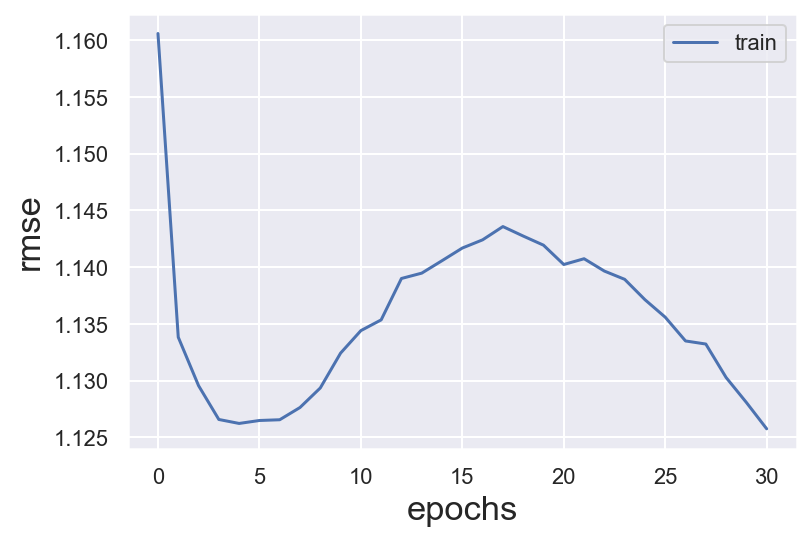

In [104]:
train_time= model.fit(X, X)

In [105]:
top_k, _ = model.recommend_k_items(X)

top_k_df = am.map_back_sparse(top_k, kind = 'prediction')

merged = pd.merge(train, top_k_df, on=["userID", "itemID"], how="outer")

all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

all_predictions.head()

,userID,itemID,prediction
810237,6040,167,3.819859
810240,6040,2198,3.793047
810238,6040,3245,3.708818
810231,6040,3095,3.608336
810236,6040,1133,3.602961


In [106]:
all_metrics['RBM'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,2930,4.758477,Return with Honor (1998),Documentary
1,1,2538,4.329006,Dancemaker (1998),Documentary
2,1,3905,4.308420,"Specials, The (2000)",Comedy
3,1,578,4.198914,"Hour of the Pig, The (1993)",Drama|Mystery
4,1,756,4.189244,Carmen Miranda: Bananas Is My Business (1994),Documentary
5,1,3314,4.183426,"Big Trees, The (1952)",Action|Drama
6,1,2198,4.089168,Modulations (1998),Documentary
7,1,3845,4.058489,And God Created Woman (Et Dieu&#8230;Créa la F...,Drama
8,1,638,4.026853,Jack and Sarah (1995),Romance
9,1,3192,4.017187,"Terrorist, The (Malli) (1998)",Drama


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,887,4.810300,Talk of Angels (1998),Drama
1,4,649,4.672323,Cold Fever (Á köldum klaka) (1994),Comedy|Drama
2,4,746,4.630442,Force of Evil (1948),Film-Noir
3,4,3931,4.457033,"Giant Gila Monster, The (1959)",Horror|Sci-Fi
4,4,1891,4.415644,"Ugly, The (1997)",Horror|Thriller
5,4,1822,4.412671,Meet the Deedles (1998),Children's|Comedy
6,4,2185,4.405801,I Confess (1953),Thriller
7,4,1522,4.398766,Ripe (1996),Drama
8,4,2345,4.389678,Desert Bloom (1986),Drama
9,4,1905,4.348424,Marie Baie Des Anges (1997),Drama


## 2.7 Riemannian Low-rank Matrix Completion (RLRMC)*
Matrix factorization algorithm using Riemannian conjugate gradients optimization with small memory consumption.

In [59]:
from reco_utils.recommender.rlrmc.RLRMCdataset import RLRMCdataset 
from reco_utils.recommender.rlrmc.RLRMCalgorithm import RLRMCalgorithm 

In [60]:
# Model parameters

# rank of the model, a positive integer (usually small), required parameter
rank_parameter = 10
# regularization parameter multiplied to loss function, a positive number (usually small), required parameter
regularization_parameter = 0.001
# initialization option for the model, 'svd' employs singular value decomposition, optional parameter
initialization_flag = 'svd' #default is 'random'
# maximum number of iterations for the solver, a positive integer, optional parameter
maximum_iteration = 100 #optional, default is 100
# maximum time in seconds for the solver, a positive integer, optional parameter
maximum_time = 300#optional, default is 1000

# Verbosity of the intermediate results
verbosity=0 #optional parameter, valid values are 0,1,2, default is 0
# Whether to compute per iteration train RMSE (and test RMSE, if test data is given)
compute_iter_rmse=True #optional parameter, boolean value, default is False

In [61]:
data = RLRMCdataset(train=train)

In [62]:
model = RLRMCalgorithm(rank = rank_parameter,
                       C = regularization_parameter,
                       model_param = data.model_param,
                       initialize_flag = initialization_flag,
                       maxiter=maximum_iteration,
                       max_time=maximum_time)

In [63]:
model.fit(data,verbosity=verbosity)

In [64]:
users, items, preds = [], [], []
item = list(train.itemID.unique())
for user in train.userID.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item)))

all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

In [65]:
all_metrics['RLRM'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,590,4.506551,Dances with Wolves (1990),Adventure|Drama|Western
1,1,920,4.497076,Gone with the Wind (1939),Drama|Romance|War
2,1,1387,4.475249,Jaws (1975),Action|Horror
3,1,527,4.454568,Schindler's List (1993),Drama|War
4,1,593,4.436651,"Silence of the Lambs, The (1991)",Drama|Thriller
5,1,1221,4.422231,"Godfather: Part II, The (1974)",Action|Crime|Drama
6,1,858,4.416891,"Godfather, The (1972)",Action|Crime|Drama
7,1,2067,4.415885,Doctor Zhivago (1965),Drama|Romance|War
8,1,356,4.394750,Forrest Gump (1994),Comedy|Romance|War
9,1,110,4.379135,Braveheart (1995),Action|Drama|War


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,858,5.240946,"Godfather, The (1972)",Action|Crime|Drama
1,4,2019,5.108179,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
2,4,1221,5.106323,"Godfather: Part II, The (1974)",Action|Crime|Drama
3,4,913,5.103570,"Maltese Falcon, The (1941)",Film-Noir|Mystery
4,4,912,5.093958,Casablanca (1942),Drama|Romance|War
5,4,1193,5.074344,One Flew Over the Cuckoo's Nest (1975),Drama
6,4,923,5.072578,Citizen Kane (1941),Drama
7,4,1207,5.065664,To Kill a Mockingbird (1962),Drama
8,4,1204,5.052312,Lawrence of Arabia (1962),Adventure|War
9,4,1178,5.045441,Paths of Glory (1957),Drama|War


# 3. Самописные нейрорекоммендеры
Вспомогательный код:

In [66]:
from collections import defaultdict
import torch
import torch.nn.functional as F
from torch import distributions, nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.distributions import Normal, Bernoulli, Independent

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from dataclasses import dataclass, fields

@dataclass
class Loss:
    full_loss: torch.Tensor

@dataclass
class VAELoss(Loss):
    kl_term: torch.Tensor
    reconstruction_term: torch.Tensor

def train_val_loop(model, dataloader, phase='train', optimizer=None):
    model.train(mode=(phase == 'train'))
    losses = defaultdict(list)
    total_losses = defaultdict(int)
    for x in dataloader:
        x_size = x[0].size(0)#(x[0] if isinstance(x, tuple) else x).size(0)
        with torch.set_grad_enabled(phase == 'train'):
            loss = model.loss(x)
            if phase == 'train':
                optimizer.zero_grad()
                loss.full_loss.backward()
                optimizer.step()
            
            for loss_part in fields(loss):
                losses[loss_part.name].append(getattr(loss, loss_part.name).item())
                total_losses[loss_part.name] += getattr(loss, loss_part.name).item() * x_size
        
    for loss_part in total_losses:
        total_losses[loss_part] /= len(dataloader.dataset)

    return losses, total_losses


def train_model(model, train_loader, test_loader, epochs=20, lr=1e-1):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)

    _, test_avg_losses = train_val_loop(model, dataloader=test_loader, phase='eval')
    test_losses = {loss_part: [loss_value] for loss_part, loss_value in test_avg_losses.items()}

    for epoch in trange(epochs):
        train_loss, train_avg_loss = train_val_loop(model,
                                                    dataloader=train_loader,
                                                    phase='train',
                                                    optimizer=optimizer)

        test_loss, test_avg_loss = train_val_loop(model, dataloader=test_loader, phase='eval')

        for loss_part in train_loss:
            train_losses[loss_part].extend(train_loss[loss_part])
            test_losses[loss_part].append(test_avg_loss[loss_part])

        print(f"\rEpoch {epoch}, Train loss: {train_avg_loss['full_loss']:.4f}, Test loss: {test_avg_loss['full_loss']:.4f}", flush=True, end='')

    return train_losses, test_losses


def plot_vae_training_plot(train_losses, test_losses, title):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

def save_training_plot(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('loss')

# 3.1 VAE
Выбрал VAE в качестве `любой вариант из 1й лекции по нейрорекоммендерам`, т.к. хорошо проработанный вероятностный подход + похоже, иногда, действительно используют в рекомендациях  

Standard Variational Autoencoders (VAE) for Collaborative Filtering implementation.
* https://arxiv.org/pdf/1802.05814.pdf 
* https://arxiv.org/pdf/1808.01006.pdf

In [72]:
class FC_Encoder(nn.Module):
    def __init__(self, input_shape, latent_shape, dropout_p=0.5, hidden_shape=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(input_shape, hidden_shape),
            nn.SiLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.SiLU()
        )
        self.to_mean = nn.Linear(hidden_shape, latent_shape)
        self.to_logvar = nn.Linear(hidden_shape, latent_shape)

    def forward(self, x):
        x = self.fc(x)
        return self.to_mean(x), self.to_logvar(x)

class FC_Decoder(nn.Module):
    def __init__(self, latent_shape, output_shape, hidden_shape=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_shape, hidden_shape),
            nn.SiLU(),
            nn.Linear(hidden_shape, output_shape),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

class FC_VAE(nn.Module):
    def __init__(self, input_shape, latent_shape, output_shape, dropout_p=0.3, hidden_shape=128):
        super().__init__()
        self.encoder = FC_Encoder(input_shape, latent_shape, dropout_p, hidden_shape)
        self.decoder = FC_Decoder(latent_shape, output_shape, hidden_shape)
        self.latent_shape = latent_shape
    
    def forward(self, x, is_train=True):
        x = F.normalize(x, p=2, dim=1)
        mu_z, logvar_z = self.encoder(x)
        
        logvar = logvar_z if is_train else torch.ones_like(logvar_z)
        qz_x = Independent(Normal(loc=mu_z, scale=torch.exp(logvar)), reinterpreted_batch_ndims=1)
        z = qz_x.rsample()

        decoded_x = self.decoder(z)
        return (mu_z, logvar_z), z, (decoded_x)
    

    def loss(self, x):
        (mu_z, logvar_z), z, (decoded_x) = self.forward(x)
        
        reconstruction_term = F.binary_cross_entropy(decoded_x, x) 

        batch_size, d = x.size(0), self.latent_shape
        pz = Independent(Normal(loc=torch.zeros(batch_size, d).to(device), scale=torch.ones(batch_size, d).to(device)), reinterpreted_batch_ndims=1)
        qz_x = Independent(Normal(loc=mu_z, scale=torch.exp(logvar_z)), reinterpreted_batch_ndims=1)
        kl_term = distributions.kl.kl_divergence(qz_x, pz).mean()
        
        full_loss = kl_term + reconstruction_term
        return VAELoss(full_loss=full_loss, kl_term=kl_term, reconstruction_term=reconstruction_term)
    
    @torch.no_grad()
    def recommend(self, x, k, remove_seen=True):
        self.eval()
        (mu_z, logvar_z), z, (score) = self.forward(x, is_train=False)
        
        if remove_seen:
            score[x > 0] = 0
            
        _, i = torch.topk(score, k, dim=1)
        return i

In [73]:
train_dataset = torch.from_numpy(user_item_csr.toarray()).float()
test_dataset = torch.from_numpy(user_item_test_csr.toarray()).float()

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 39, Train loss: 0.0724, Test loss: 0.0375


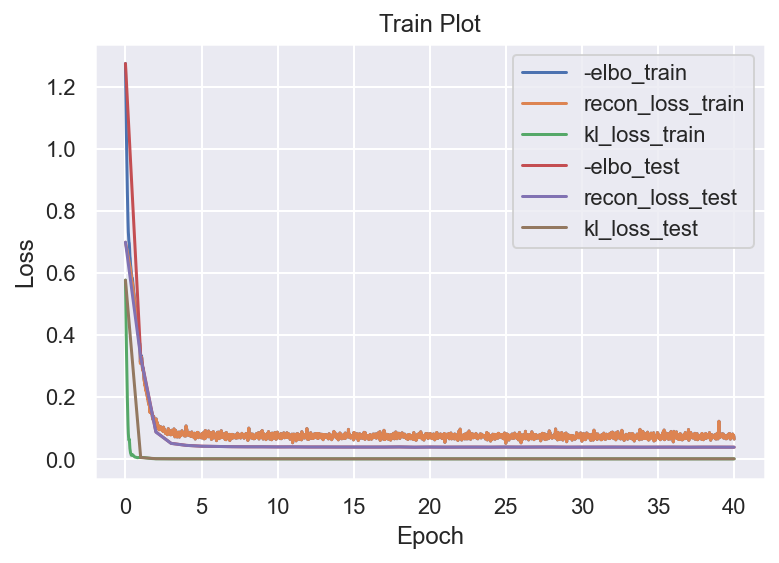

In [74]:
model = FC_VAE(input_shape=user_item_csr.shape[1], output_shape=user_item_csr.shape[1], latent_shape=128)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=40, lr=1e-3)
train_losses = np.stack((train_losses['full_loss'], train_losses['reconstruction_term'], train_losses['kl_term']), axis=1)
test_losses = np.stack((test_losses['full_loss'], test_losses['reconstruction_term'], test_losses['kl_term']), axis=1)
plot_vae_training_plot(train_losses, test_losses, 'Train Plot')

In [75]:
ratings_predictions = model.recommend(train_dataset, k=TOP_K)

In [76]:
predictions = pd.DataFrame(np.arange(ratings_predictions.shape[0]), columns=['userID'])

predictions['itemID'] = ratings_predictions.tolist()

predictions = predictions[predictions['userID'].isin(train['userID'].unique())]

predictions = predictions.explode('itemID', ignore_index=True)

predictions['itemID'] = predictions['itemID'].astype(np.int64)

predictions['prediction'] = TOP_K - predictions.index % TOP_K

In [77]:
all_metrics['vae'] = test_model_perfomance(predictions)

Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,2858,10,American Beauty (1999),Comedy|Drama
1,1,1196,9,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
2,1,1210,8,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
3,1,527,7,Schindler's List (1993),Drama|War
4,1,589,6,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
5,1,593,5,"Silence of the Lambs, The (1991)",Drama|Thriller
6,1,858,4,"Godfather, The (1972)",Action|Crime|Drama
7,1,1198,3,Raiders of the Lost Ark (1981),Action|Adventure
8,1,110,2,Braveheart (1995),Action|Drama|War
9,1,2571,1,"Matrix, The (1999)",Action|Sci-Fi|Thriller


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,2858,10,American Beauty (1999),Comedy|Drama
1,4,1196,9,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
2,4,1210,8,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
3,4,858,7,"Godfather, The (1972)",Action|Crime|Drama
4,4,110,6,Braveheart (1995),Action|Drama|War
5,4,2571,5,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6,4,589,4,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
7,4,593,3,"Silence of the Lambs, The (1991)",Drama|Thriller
8,4,608,2,Fargo (1996),Crime|Drama|Thriller
9,4,318,1,"Shawshank Redemption, The (1994)",Drama


## 3.2 Simple Attention
Решил использовать `Attentional factorization machines: Learning the weight of feature interactions via attention networks` ([arxiv](https://arxiv.org/abs/1708.04617))

![afm](https://deeptables.readthedocs.io/en/latest/_images/afm.png)

Сильно помогло negative sampling и [MarginRankingLoss](https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html#torch.nn.MarginRankingLoss)

In [91]:
class AttentionDataset(Dataset):
    def __init__(self, df, user_col='userID', item_col='itemID', rating_col='rating', n_negative=5, implicit_bound_value=4):
        df = df[df[rating_col] >= implicit_bound_value]
        self.items = df[[user_col, item_col]].values - 1
        self.n_items = df[item_col].max()
        self.positive = df.groupby(user_col)[item_col].apply(set)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.n_negative = n_negative
    
    def __len__(self):
        return self.items.shape[0] * self.n_negative
    
    def __getitem__(self, i):
        i = i // self.n_negative
        positive_item = self.items[i]
        user_id = positive_item[0]
        
        while True:
            negative = torch.randint(self.n_items, (1,))
            if negative.item() not in self.positive[user_id + 1]:
                break
                
        return positive_item, torch.cat([torch.tensor([user_id]), negative])

In [92]:
class FeaturesEmbedding(torch.nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)
    
class FeaturesLinear(torch.nn.Module):
    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias
    
class AttentionalFactorizationMachine(torch.nn.Module):
    def __init__(self, embed_dim, attn_size, dropouts):
        super().__init__()
        self.attention = torch.nn.Linear(embed_dim, attn_size)
        self.projection = torch.nn.Linear(attn_size, 1)
        self.fc = torch.nn.Linear(embed_dim, 1)
        self.dropouts = dropouts

    def forward(self, x):
        num_fields = x.shape[1]
        row, col = list(), list()
        for i in range(num_fields - 1):
            for j in range(i + 1, num_fields):
                row.append(i), col.append(j)
        p, q = x[:, row], x[:, col]
        inner_product = p * q
        attn_scores = F.relu(self.attention(inner_product))
        attn_scores = F.softmax(self.projection(attn_scores), dim=1)
        attn_scores = F.dropout(attn_scores, p=self.dropouts[0], training=self.training)
        attn_output = torch.sum(attn_scores * inner_product, dim=1)
        attn_output = F.dropout(attn_output, p=self.dropouts[1], training=self.training)
        return self.fc(attn_output)
        
class AttentionalFactorizationMachineModel(torch.nn.Module):
    def __init__(self, field_dims, embed_dim, attn_size, dropouts, margin=0.4):
        super().__init__()
        self.num_fields = len(field_dims)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.afm = AttentionalFactorizationMachine(embed_dim, attn_size, dropouts)
        self.margin = margin

    def forward(self, x):
        x = self.linear(x) + self.afm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

    def loss(self, x):
        p, n = x
        prob_pos = self.forward(p)
        prob_neg = self.forward(n)
        
        y = torch.ones(p.size(0))

        return Loss(full_loss=F.margin_ranking_loss(prob_pos, prob_neg, y, self.margin))  

In [93]:
train_dataset = AttentionDataset(train)
test_dataset = AttentionDataset(test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [94]:
model = AttentionalFactorizationMachineModel(train_dataset.field_dims, embed_dim=64, attn_size=16, dropouts=(0.2, 0.2))
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=7, lr=1e-3)

Epoch 6, Train loss: 0.0663, Test loss: 0.1647


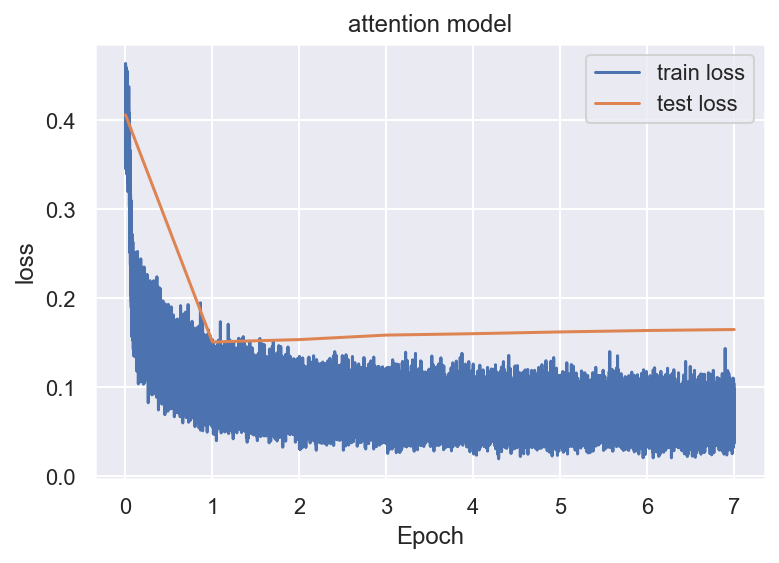

In [95]:
save_training_plot(train_losses['full_loss'], test_losses['full_loss'], 'attention model')

In [96]:
model.eval()
users, items, preds = [], [], []
item = torch.from_numpy(test.itemID.unique())
for user in test.userID.unique():
    a = torch.full((item.size(0),), user-1)
    t = torch.stack([a, item - 1], dim=1).view(-1, 2)
    with torch.no_grad():
        pred = model(t).detach().cpu().tolist()
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item.tolist())
    preds.extend(pred)

In [97]:
all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
all_predictions = all_predictions.sort_values(['userID','prediction'],ascending=False).groupby('userID').head(TOP_K).drop(columns=['timestamp', 'title'])

In [98]:
all_metrics['attention'] = test_model_perfomance(all_predictions)

Рекомендации для пользователя: 1


,userID,itemID,prediction,title,genres
0,1,2858,1.000000,American Beauty (1999),Comedy|Drama
1,1,593,1.000000,"Silence of the Lambs, The (1991)",Drama|Thriller
2,1,1198,1.000000,Raiders of the Lost Ark (1981),Action|Adventure
3,1,1210,1.000000,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
4,1,1196,1.000000,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
5,1,318,1.000000,"Shawshank Redemption, The (1994)",Drama
6,1,527,1.000000,Schindler's List (1993),Drama|War
7,1,2396,0.999993,Shakespeare in Love (1998),Comedy|Romance
8,1,110,0.999914,Braveheart (1995),Action|Drama|War
9,1,589,0.999802,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller


Рекомендации для пользователя: 4


,userID,itemID,prediction,title,genres
0,4,1197,0.999998,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
1,4,2858,0.999998,American Beauty (1999),Comedy|Drama
2,4,593,0.999990,"Silence of the Lambs, The (1991)",Drama|Thriller
3,4,1270,0.999958,Back to the Future (1985),Comedy|Sci-Fi
4,4,527,0.999873,Schindler's List (1993),Drama|War
5,4,110,0.999819,Braveheart (1995),Action|Drama|War
6,4,2571,0.999745,"Matrix, The (1999)",Action|Sci-Fi|Thriller
7,4,2762,0.999719,"Sixth Sense, The (1999)",Thriller
8,4,589,0.999645,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
9,4,318,0.999613,"Shawshank Redemption, The (1994)",Drama


# 4. Оценка результатов

In [122]:
get_metrics(all_metrics)

,bpr_implicit,sar,fastai,NCF,RBM,RLRM,vae,attention
metric,,,,,,,,
map_at_3,0.010659,0.017183,0.007806,0.013572,0.000448,0.007517,0.008593,0.008655
ndcg_at_3,0.099191,0.176919,0.115488,0.164162,0.018252,0.112193,0.116256,0.139376
precision_at_3,0.098101,0.175883,0.113135,0.161369,0.018322,0.108609,0.113576,0.138079
recall_at_3,0.015792,0.023848,0.010949,0.019069,0.000738,0.010587,0.011923,0.012336
map_at_5,0.013555,0.022580,0.010184,0.018029,0.000552,0.009562,0.010936,0.011534
ndcg_at_5,0.095469,0.172514,0.110555,0.159507,0.016881,0.105116,0.110703,0.137048
precision_at_5,0.093077,0.169934,0.106987,0.155795,0.016291,0.099834,0.106556,0.135166
recall_at_5,0.024554,0.037361,0.017381,0.030818,0.001132,0.016208,0.017982,0.019709
map_at_10,0.018585,0.031148,0.014128,0.025027,0.000729,0.012818,0.015197,0.017045


Построим также *Average Treatment Effect* — насколько модели лучше/хуже, относительно базовой

In [123]:
get_ate(all_metrics, control_name='bpr_implicit')

,sar,fastai,NCF,RBM,RLRM,vae,attention
metric,,,,,,,
map_at_3,0.652351,-0.285323,0.291268,-1.021161,-0.314194,-0.206627,-0.200413
ndcg_at_3,7.772806,1.629685,6.497050,-8.093952,1.300225,1.706451,4.018509
precision_at_3,7.778209,1.503374,6.326774,-7.977862,1.050836,1.547524,3.997855
recall_at_3,0.805549,-0.484260,0.327711,-1.505434,-0.520475,-0.386895,-0.345621
map_at_5,0.902552,-0.337053,0.447432,-1.300291,-0.399227,-0.261899,-0.202074
ndcg_at_5,7.704489,1.508614,6.403821,-7.858860,0.964656,1.523399,4.157923
precision_at_5,7.685660,1.390958,6.271752,-7.678579,0.675726,1.347911,4.208839
recall_at_5,1.280693,-0.717274,0.626353,-2.342213,-0.834591,-0.657232,-0.484467
map_at_10,1.256276,-0.445690,0.644198,-1.785612,-0.576650,-0.338795,-0.153990
